<a href="https://colab.research.google.com/github/megmarv/AI-BioLabs/blob/Diabetes-UT-Classification/ResNet50_DFU_UT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Cell 2: Set Dataset Paths and Class Names
dataset_base = "/content/drive/MyDrive/DFU_UT_Dataset"
train_dir = os.path.join(dataset_base, "balanced_training")
test_dir = os.path.join(dataset_base, "balanced_validation")
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
print("Class Names:", class_names)

Class Names: ['Grade 0', 'Grade 1', 'Grade 2', 'Grade 3', 'Normal(Healthy skin)']


Training Class Distribution: {'Grade 0': 106, 'Grade 1': 141, 'Grade 2': 152, 'Grade 3': 124, 'Normal(Healthy skin)': 152}
Validation Class Distribution: {'Grade 0': 20, 'Grade 1': 20, 'Grade 2': 20, 'Grade 3': 20, 'Normal(Healthy skin)': 20}


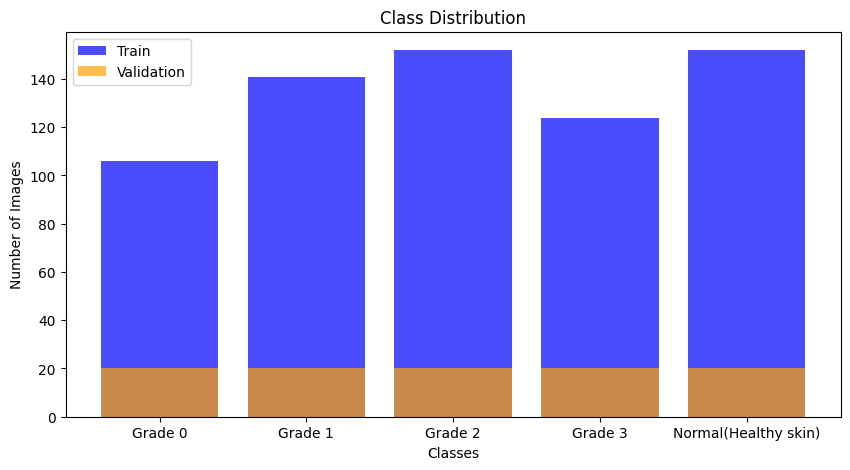

In [ ]:
# Cell 3: EDA - Class Distribution
class_counts_train = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}
class_counts_test = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in class_names}
print("Training Class Distribution:", class_counts_train)
print("Validation Class Distribution:", class_counts_test)

plt.figure(figsize=(10, 5))
plt.bar(class_counts_train.keys(), class_counts_train.values(), color='blue', alpha=0.7, label='Train')
plt.bar(class_counts_test.keys(), class_counts_test.values(), color='orange', alpha=0.7, label='Validation')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.legend()
plt.show()

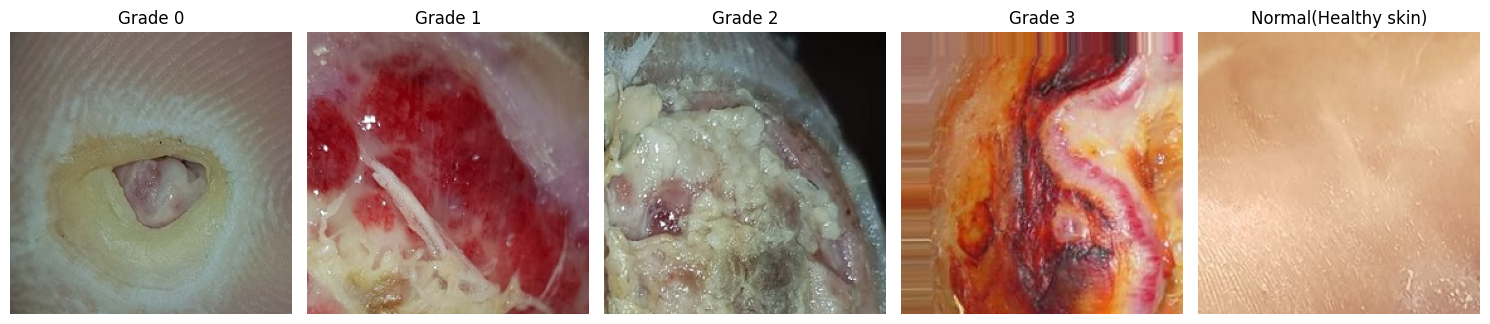

In [ ]:
# Cell 4: EDA - Sample Images
plt.figure(figsize=(15, 5))
for i, cls in enumerate(class_names):
    cls_dir = os.path.join(train_dir, cls)
    img_name = random.choice(os.listdir(cls_dir))
    img_path = os.path.join(cls_dir, img_name)
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(1, len(class_names), i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Cell 5: Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=45,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='reflect',
    brightness_range=[0.6, 1.4],
    channel_shift_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    shuffle=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1]
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    shuffle=False
)

Found 675 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [ ]:
# Cell 6: Compute Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))
# Double the weight for Grade 2 (index 2)
class_weight_dict[2] = class_weight_dict[2] * 2.0
print("Class Weights:", class_weight_dict)

Class Weights: {0: np.float64(1.2735849056603774), 1: np.float64(0.9574468085106383), 2: np.float64(1.7763157894736843), 3: np.float64(1.0887096774193548), 4: np.float64(0.8881578947368421)}


In [ ]:
# Cell 7: Build and Compile Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,141 (90.98 MB)

 Trainable params: 263,173 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

In [ ]:
# Cell 8: Initial Training
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

history_initial = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=10,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 271s 6s/step - accuracy: 0.2376 - loss: 3.1877 - val_accuracy: 0.6400 - val_loss: 1.2732 - learning_rate: 1.0000e-04
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 74s 337ms/step - accuracy: 0.4679 - loss: 2.0814 - val_accuracy: 0.7500 - val_loss: 1.0136 - learning_rate: 1.0000e-04
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 334ms/step - accuracy: 0.5291 - loss: 1.8465 - val_accuracy: 0.7900 - val_loss: 0.8592 - learning_rate: 1.0000e-04
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 332ms/step - accuracy: 0.6419 - loss: 1.4438 - val_accuracy: 0.8100 - val_loss: 0.8285 - learning_rate: 1.0000e-04
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 328ms/step - accuracy: 0.6331 - loss: 1.4080 - val_accuracy: 0.8000 - val_loss: 0.7764 - learning_rate: 1.0000e-04
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - accuracy: 0.7235 - loss: 1.2506 - val_accuracy: 0.8500 - val_loss: 0.6700 - learning_rate: 1.0000e-04
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 327ms/step - accur

In [ ]:
# Cell 9: Fine-Tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Unfreeze last 20 layers
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),  # Changed to Adam with lr=1e-5
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=15,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict
)

Epoch 1/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 604ms/step - accuracy: 0.7561 - loss: 1.0872 - val_accuracy: 0.8600 - val_loss: 0.6008 - learning_rate: 1.0000e-05
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 333ms/step - accuracy: 0.7144 - loss: 1.2482 - val_accuracy: 0.8500 - val_loss: 0.5986 - learning_rate: 1.0000e-05
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 329ms/step - accuracy: 0.7205 - loss: 1.2514 - val_accuracy: 0.8400 - val_loss: 0.6433 - learning_rate: 1.0000e-05
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 333ms/step - accuracy: 0.7660 - loss: 1.1257 - val_accuracy: 0.8600 - val_loss: 0.5891 - learning_rate: 1.0000e-05
Epoch 5/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 328ms/step - accuracy: 0.7686 - loss: 0.9879 - val_accuracy: 0.8600 - val_loss: 0.6439 - learning_rate: 1.0000e-05
Epoch 6/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step - accuracy: 0.7694 - loss: 1.0599 - val_accuracy: 0.8300 - val_loss: 0.6282 - learning_rate: 1.0000e-05
Epoch 7/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step - acc

In [ ]:
# Cell 10: Combine Histories and Plot
history = {
    'accuracy': history_initial.history['accuracy'] + history_fine.history['accuracy'],
    'val_accuracy': history_initial.history['val_accuracy'] + history_fine.history['val_accuracy'],
    'loss': history_initial.history['loss'] + history_fine.history['loss'],
    'val_loss': history_initial.history['val_loss'] + history_fine.history['val_loss']
}

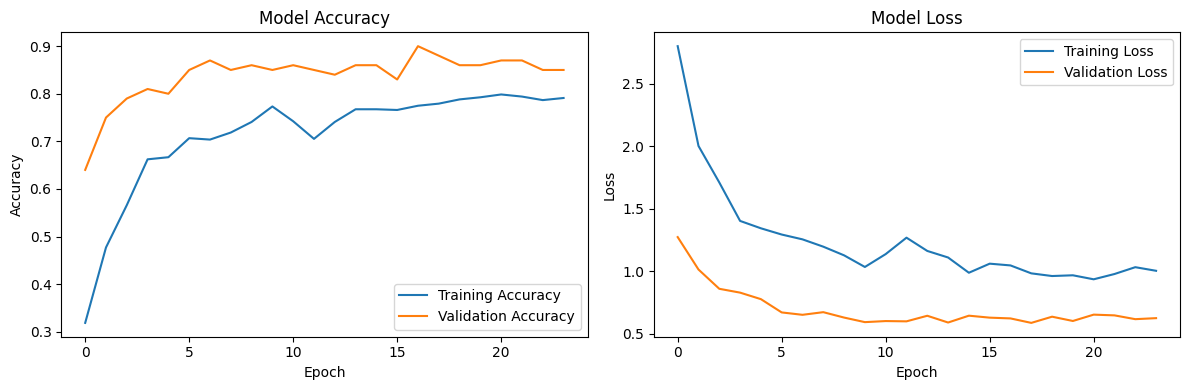

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Cell 11: Evaluate Model
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred)]

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%\n")
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 714ms/step
Accuracy: 86.00%

Classification Report:

                      precision    recall  f1-score   support

             Grade 0       0.72      0.90      0.80        20
             Grade 1       1.00      0.95      0.97        20
             Grade 2       0.76      0.80      0.78        20
             Grade 3       0.89      0.85      0.87        20
Normal(Healthy skin)       1.00      0.80      0.89        20

            accuracy                           0.86       100
           macro avg       0.88      0.86      0.86       100
        weighted avg       0.88      0.86      0.86       100



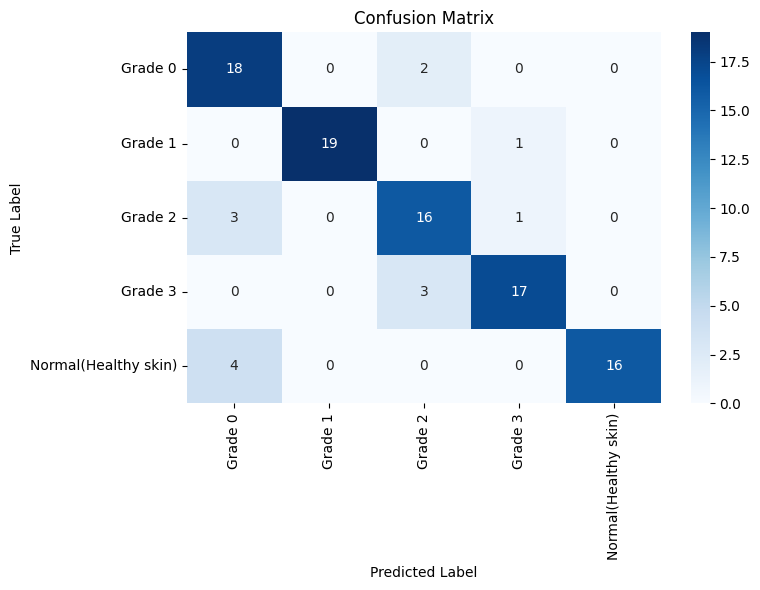

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

<ipython-input-14-980396595>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=label_accuracies, palette='viridis')


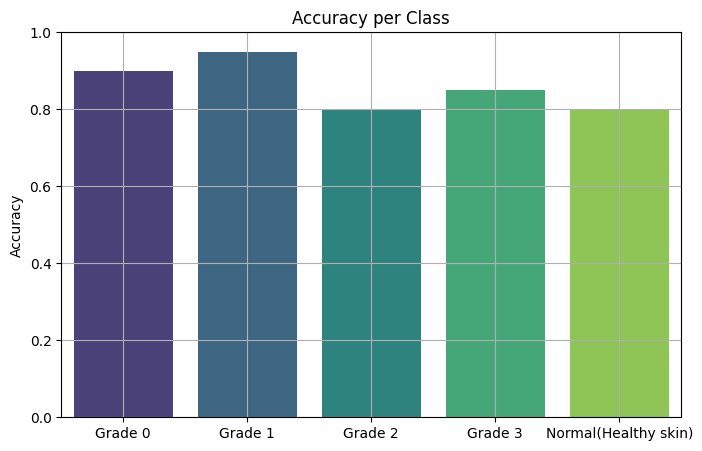

In [ ]:
correct = (y_pred_classes == y_true)
label_accuracies = []
for i, class_name in enumerate(class_names):
    indices = (y_true == i)
    acc = np.sum(correct[indices]) / np.sum(indices) if np.sum(indices) > 0 else 0
    label_accuracies.append(acc)

plt.figure(figsize=(8, 5))
sns.barplot(x=class_names, y=label_accuracies, palette='viridis')
plt.ylabel("Accuracy")
plt.title("Accuracy per Class")
plt.ylim(0, 1.0)
plt.grid(True)
plt.show()

In [ ]:
# Cell 12: Save Model
model.save("finetuned_resnet50_v4.h5")
print("Model saved successfully.")

Model saved successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


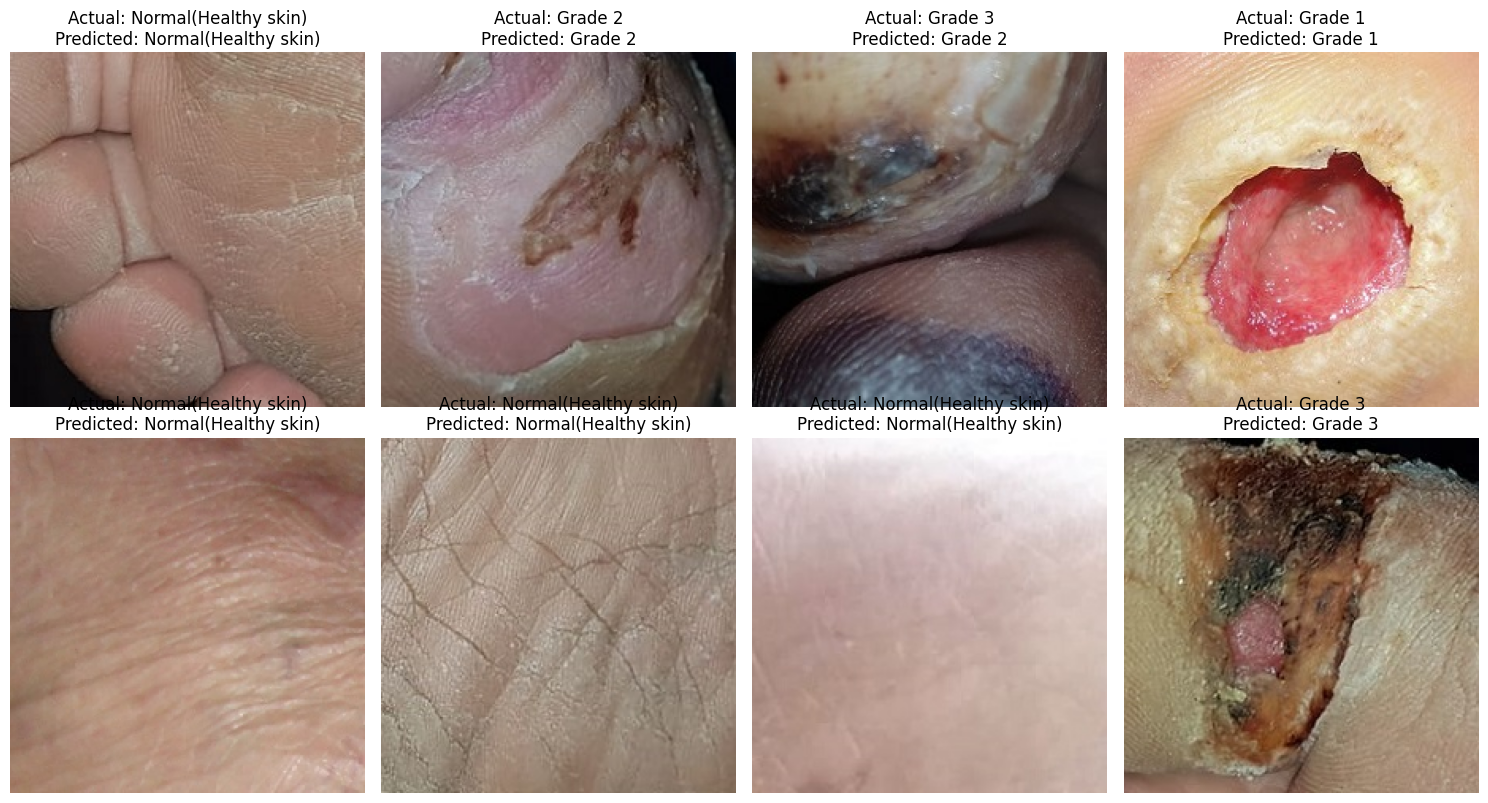

In [ ]:
# Cell 13: Display Predictions on Random Test Images
test_images = [os.path.join(test_dir, cls, img) for cls in os.listdir(test_dir)
               for img in os.listdir(os.path.join(test_dir, cls))]
indices = random.sample(range(len(test_images)), min(8, len(test_images)))
selected_images = [test_images[i] for i in indices]
selected_labels = [class_names.index(os.path.basename(os.path.dirname(img))) for img in selected_images]

selected_images_preprocessed = []
for img_path in selected_images:
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    selected_images_preprocessed.append(x)

X_selected = np.vstack(selected_images_preprocessed)
predictions = np.argmax(model.predict(X_selected), axis=1)

plt.figure(figsize=(15, 8))
for i in range(len(selected_images)):
    img = load_img(selected_images[i], target_size=(224, 224))
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    actual = class_names[selected_labels[i]]
    predicted = class_names[predictions[i]]
    plt.title(f"Actual: {actual}\nPredicted: {predicted}")
    plt.axis('off')
plt.tight_layout()
plt.show()